In [13]:
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt
import astropy.units as u
import os
import sys
import time
from scipy.stats import chisquare
from datetime import datetime
from astropy.coordinates import SkyCoord
#import ConfigParser as cp
import matplotlib
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
import emcee

In [14]:
class color:
   PURPLE = '\033[1;35;48m'
   CYAN = '\033[1;36;48m'
   BOLD = '\033[1;37;48m'
   BLUE = '\033[1;34;48m'
   GREEN = '\033[1;32;48m'
   YELLOW = '\033[1;33;48m'
   RED = '\033[1;31;48m'
   BLACK = '\033[1;30;48m'
   UNDERLINE = '\033[4;37;48m'
   END = '\033[1;37;0m'

In [15]:
local_path='/Users/adrianhernandez/JPL_2021/'
sys.path.append(local_path + 'MulensModel_master/source')
import MulensModel as mm
from MulensModel.utils import Utils

In [16]:
##import data 

from glob import glob
im_dir = '/Users/adrianhernandez/JPL_2021/ukirt_files/'
ukirt_file = glob(f"{im_dir}/*97661*.txt")
print(ukirt_file[1]) #change indicies to update the file you are interested with
filename = ukirt_file[1][44:66]
ukirt_data = np.loadtxt(ukirt_file[1], usecols=range(3))
print(len(ukirt_data))
print(filename)



/Users/adrianhernandez/JPL_2021/ukirt_files/UK2017_c4_2_4_K_C97661.txt
548
UK2017_c4_2_4_K_C97661


In [24]:
#create arrays for time, magnitude, and error 
ukirt_time = ukirt_data[:,0]-2450000 # - 2450000 for ukirt data 
reg_ukirt_time = ukirt_data[:,0]
ukirt_mag = ukirt_data[:,1]
ukirt_error = ukirt_data[:,2]
data_points = len(ukirt_data)


In [18]:
# where_inf=np.where(ukirt_data ==np.inf)
# ukirt_data[where_inf]=np.mean((ukirt_data[where_inf[0][0]-1,where_inf[1][0]],
#                                 ukirt_data[where_inf[0][0]+1,where_inf[1][0]]))

<IPython.core.display.Javascript object>


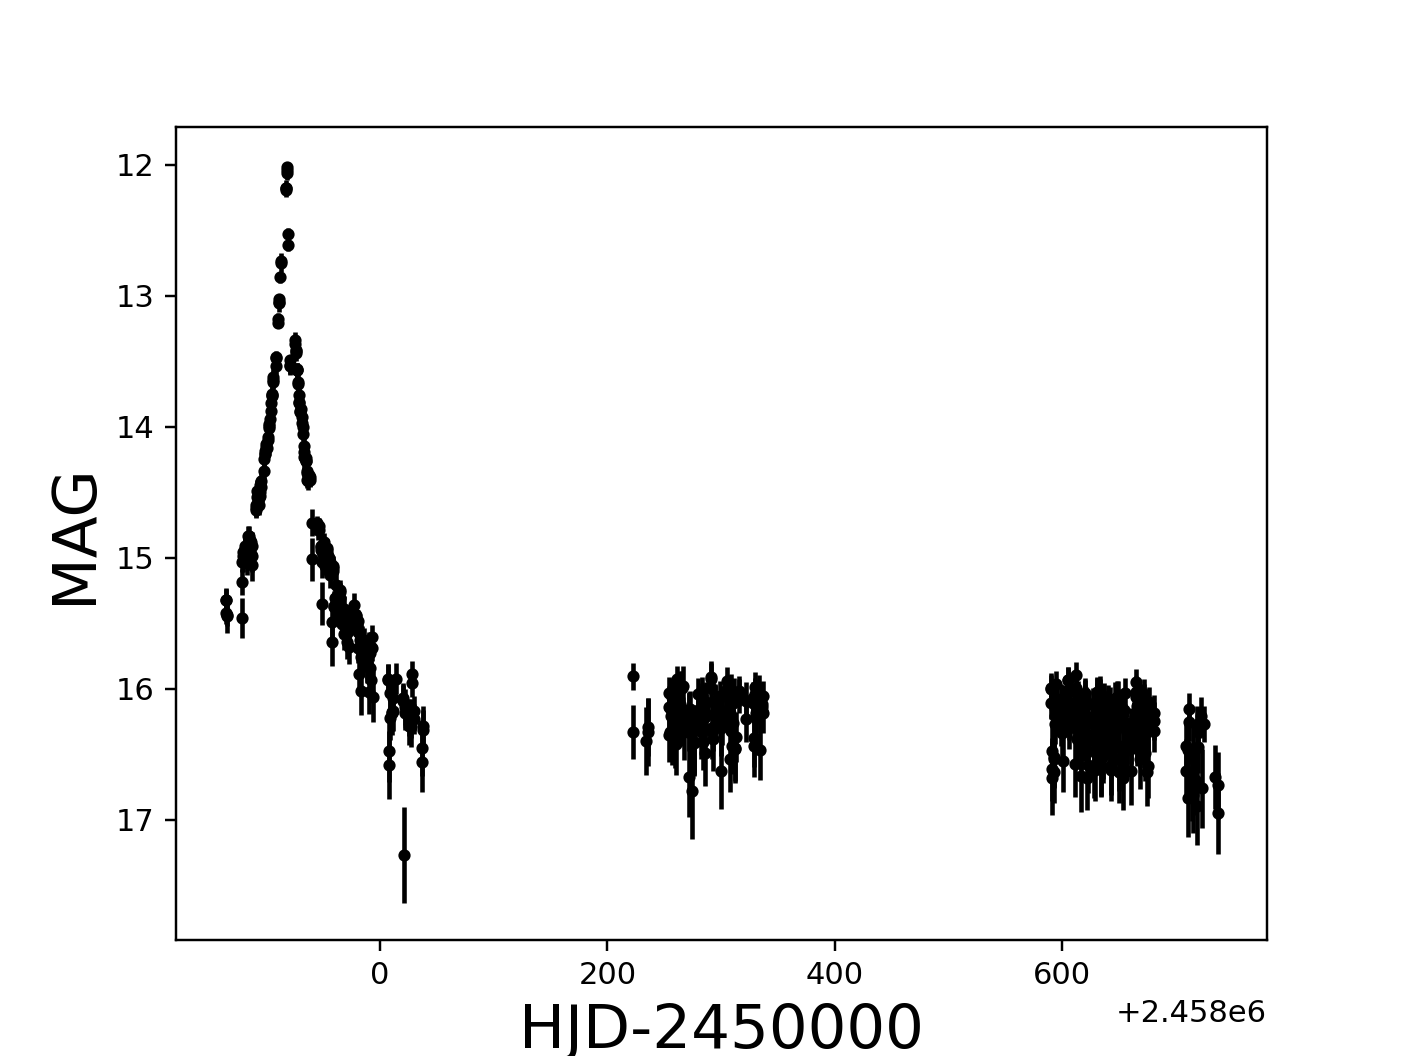

In [19]:
%matplotlib notebook

#looking at data with error bars 

plt.errorbar(reg_ukirt_time, ukirt_mag,yerr = ukirt_error,fmt='.k')
plt.xlabel('HJD-2450000',fontsize=20)
plt.ylabel('MAG',fontsize=20)
#plt.xlim(7895,7940)
plt.gca().invert_yaxis()
plt.show()

In [20]:
base_est = np.mean(ukirt_mag[300:583]) 
print(color.BLUE +'Estimated Baseline magnification ='+ color.END,base_est)
peak_est = min(ukirt_mag)
print(color.BLUE +'Estimated Event peak magnification ='+ color.END,peak_est)
del_mag_est = base_est - peak_est 
print(color.BLUE +'Estimated Change in magnification ='+ color.END,del_mag_est)
to_est = ukirt_time[ukirt_mag.argmin()]+2450000 #2458588.82653
print(color.BLUE +'Estimated Time at which peak magnification occurs ='+ color.END,to_est)
A_FWHM = (base_est + peak_est)/2
print(color.BLUE +'FWHM occurs at'+ color.END,A_FWHM)
width = np.full((1,data_points),A_FWHM)
idx = np.argwhere(np.diff(np.sign(width - ukirt_mag))).flatten()
print(ukirt_time[idx])
FWHM = ukirt_time[idx][7]-ukirt_time[idx][0]
print(color.BLUE +'The estimated FWHM is'+ color.END,FWHM)
sig_est = FWHM/2.355
print(color.BLUE +'The estimated simga is'+ color.END,sig_est)

Estimated Baseline magnification = 16.270862903225808
Estimated Event peak magnification = 12.019
Estimated Change in magnification = 4.251862903225808
Estimated Time at which peak magnification occurs = 2457917.90594
FWHM occurs at 14.144931451612905
[7864.0234  7899.96734 7864.0234  7900.00643 7864.0234  7900.05628
 7864.0234  7931.94805]
The estimated FWHM is 67.92464999994263
The estimated simga is 28.842738853478824


In [21]:
def Light_curve(reg_ukirt_time,delta_mag,peak_time,sigma,base_mag):
    return -delta_mag*np.exp(-((reg_ukirt_time - peak_time)**2 / (2*sigma**2))) + base_mag

In [22]:
p_guess = [del_mag_est,to_est,sig_est,base_est] 
popt = curve_fit(Light_curve, reg_ukirt_time, ukirt_mag, p0 = p_guess)
del_mag = popt[0][0]
print(color.BLUE +'Fitted change in magnitude ='+ color.END,del_mag)
sigma = popt[0][2]
print(color.BLUE +'Fitted simga ='+ color.END,sigma)
baseline = popt[0][3]
print(color.BLUE +'Fitted baseline magnitude ='+ color.END, baseline)
#Parameter A tells by how much the lensing event increased the baseline magnifiction 
A = 10**((del_mag_est)/2.5) 
print(color.PURPLE +'Magnification increased by'+ color.END,A)
#Minimum separation of the impact parameter is related to parameter A by 
initial_u0 = 1/A
print(color.PURPLE +'Estimated minimum event separation, inital_u0 ='+ color.END,initial_u0)
#Fitted peak event time calulated during curve fit 
initial_t0 = popt[0][1]
print(color.PURPLE +'Fitted peak event time, initial_t0 ='+ color.END,initial_t0)
#Estimated Einstein Crossing time 
initial_tE = (sigma*2.355)/(2)
print(color.PURPLE +'The estimated Einstein crossing time is, inital_t_E'+ color.END,initial_tE)


Fitted change in magnitude = 2.811853941205317
Fitted simga = 28.120276272212553
Fitted baseline magnitude = 16.222246573455152
Magnification increased by 50.20479074787639
Estimated minimum event separation, inital_u0 = 0.01991841784625502
Fitted peak event time, initial_t0 = 2457917.482461469
The estimated Einstein crossing time is, inital_t_E 33.11162531053028


In [ ]:
#for debugging 
#ukirt 070553 initial estimates 
#inital_u0 = 0.2273976645368199
#initial_t0 = 2454365.361957518
#inital_t_E 8.770121776240087
# ok the above works 

#trying ukirt_03056
# inital_u0 = 0.27718772880438836
#initial_t0 = 2452759.1929484894
#inital_t_E 30.209468875098334
#above does not work 

#trying ukirt_0939
# inital_u0 = 0.6723075679569629
#initial_t0 = 2456836.278953031
#inital_t_E 23.69400876161069



original PARAMS:  {'u0': 0.01991841784625502, 't0': 7917.482461468782, 'tE': 33.11162531053028, 'Ftot': 16.0585, 'fb': 0.99, 'chi2': 1, 'chi2red': 1}
initializing walkers
('OK: smaller range2 for JD init', 7917.482461468782)
running mcmc for ground-based data
 setting the burn in
 doing the final run
(' Acceptance fraction:', 0.6094444444444443)
 not doing the autocorr check.  trouble here!
('FIT RESULT:', '      u0', '=', '      0.0201', '+-', ' 0.00048')
(' | chi offset =', ' 0.31')
  0.0
('FIT RESULT:', '      tE', '=', '    108.9853', '+-', ' 0.88334')
(' | chi offset =', '85.89')
  0.0
('FIT RESULT:', '      t0', '=', '   7916.0040', '+-', ' 0.04345')
(' | chi offset =', '-34.02')
  0.0
('FIT RESULT:', '    Ftot', '=', '     16.2526', '+-', ' 0.00207')
(' | chi offset =', '93.90')
  0.0
('FIT RESULT:', '      fb', '=', '      0.9930', '+-', ' 0.00689')
(' | chi offset =', ' 0.44')
  0.0
None
bestIndex 14725
 param old,new values: u0 0.02006595493648921 0.020222720774864797
 param 

<IPython.core.display.Javascript object>


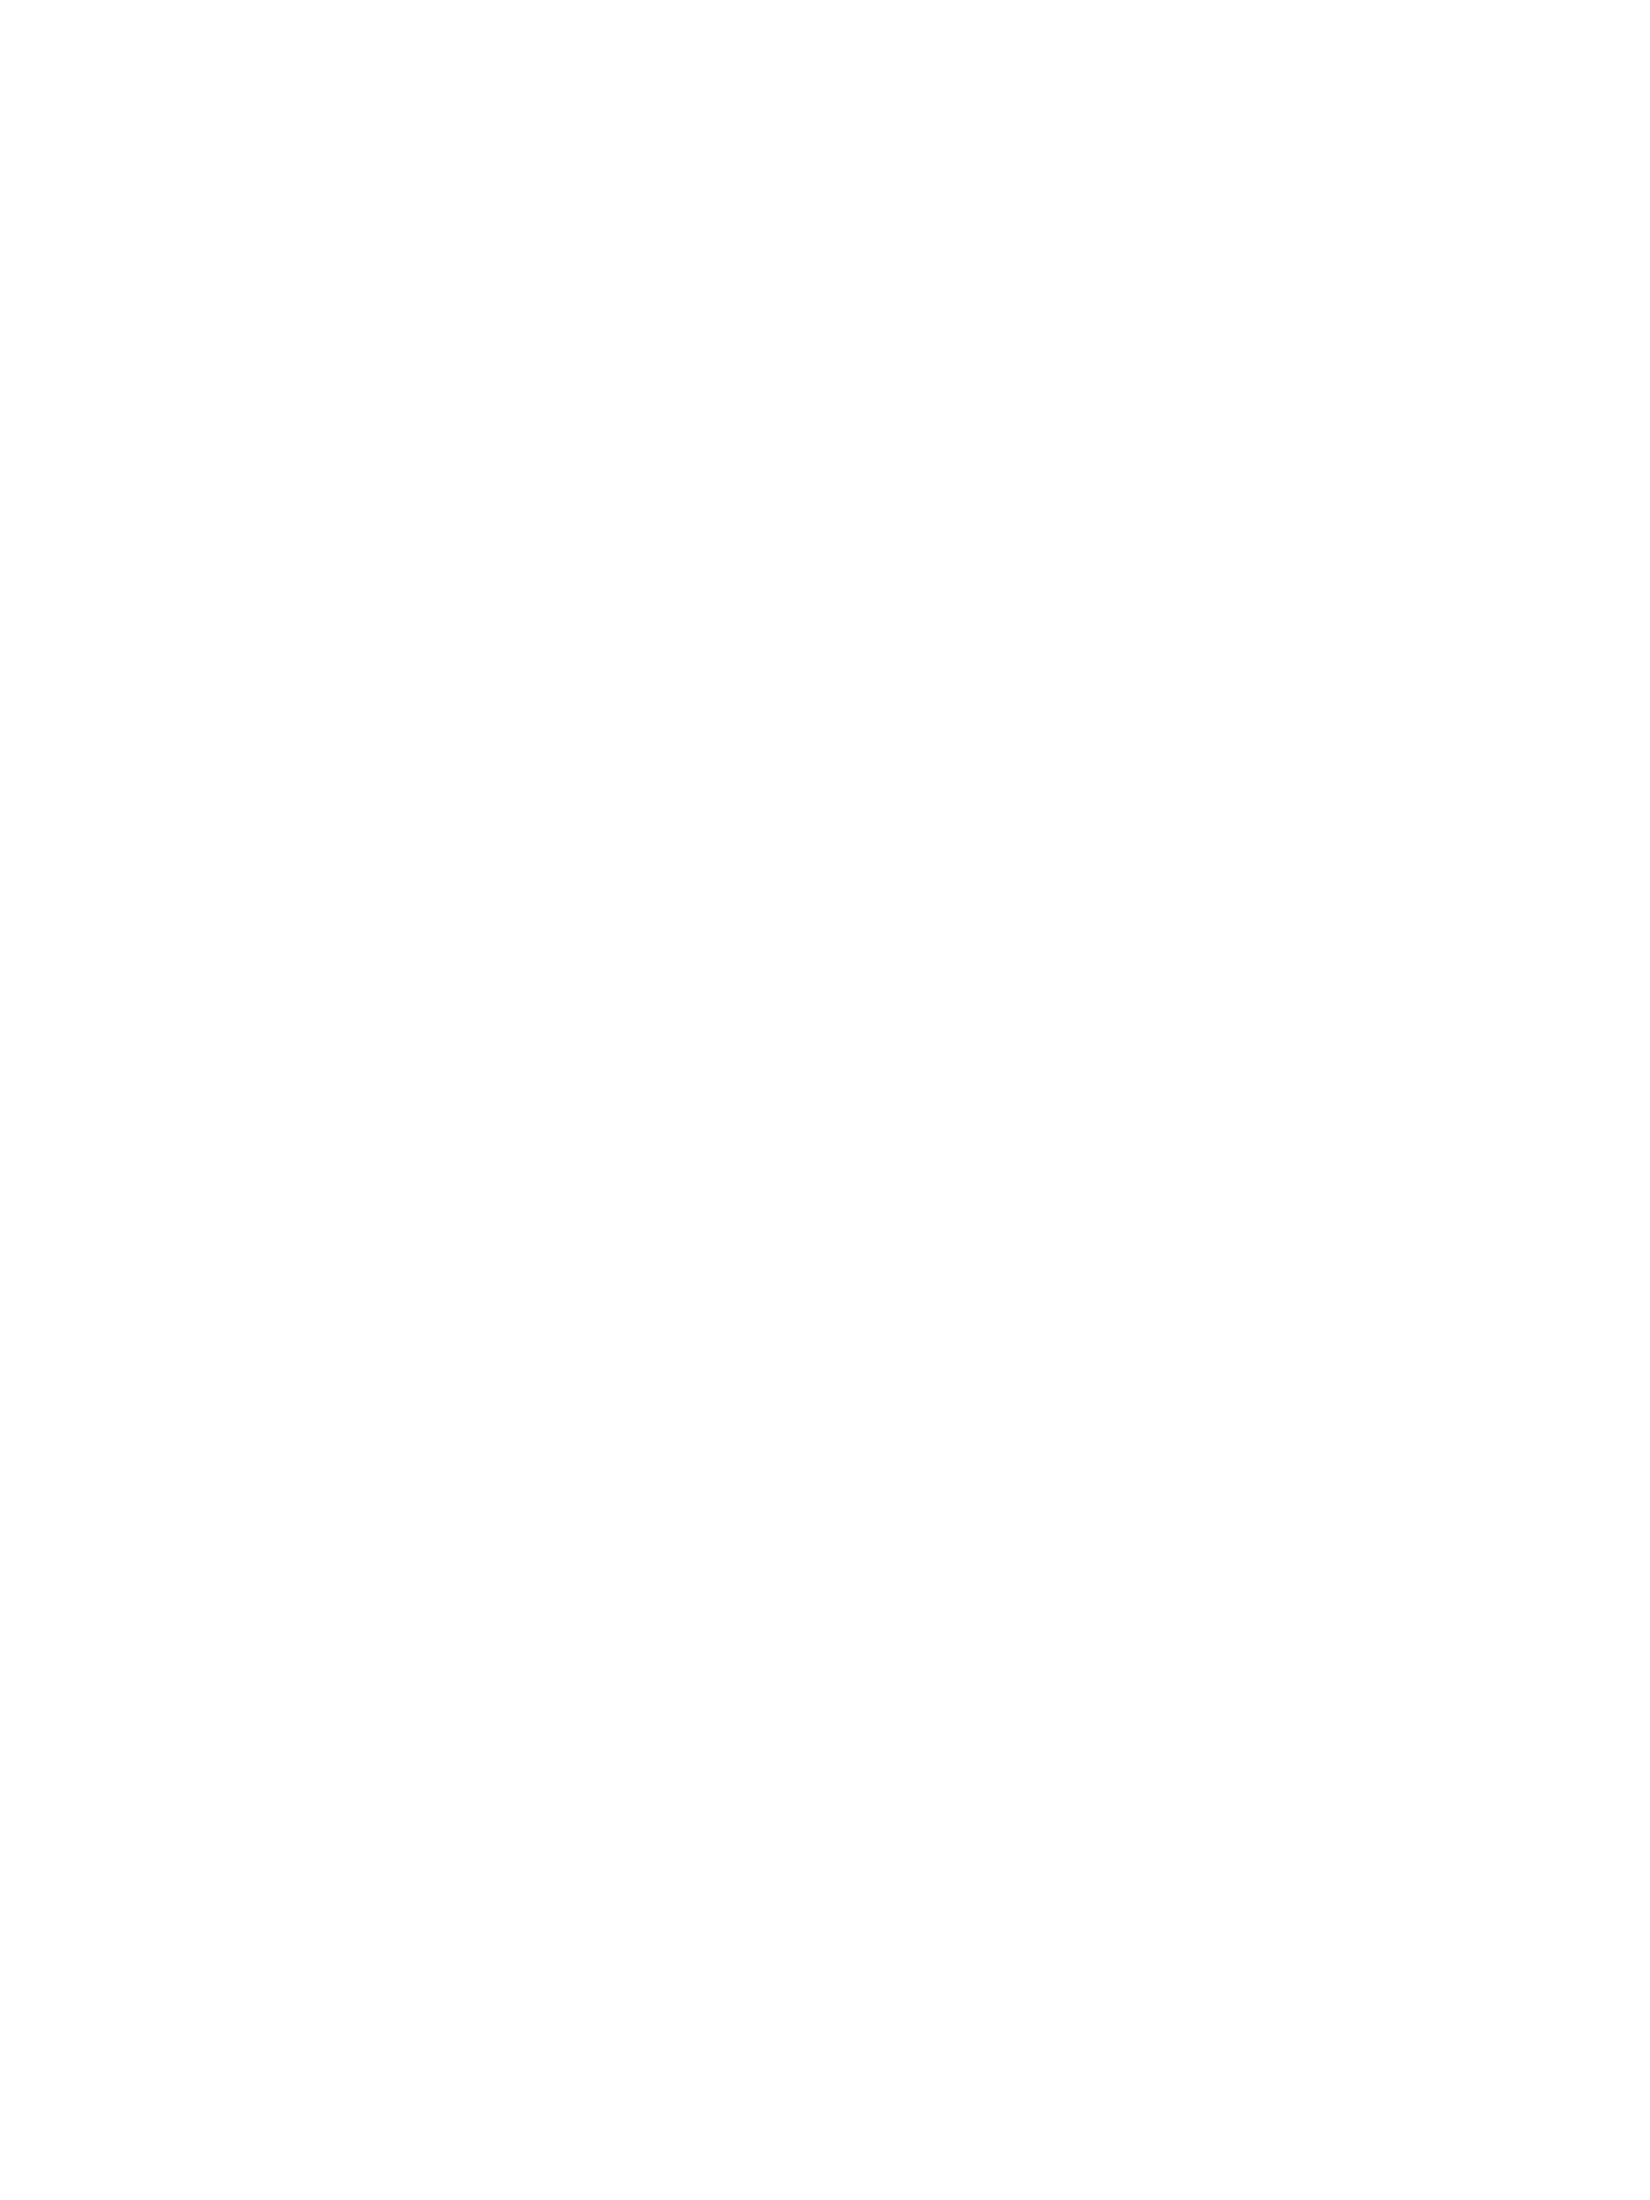

initialGuess {'u0': 0.01991841784625502, 't0': 7917.482461468782, 'tE': 33.11162531053028, 'Ftot': 16.0585, 'fb': 0.99, 'chi2': 1, 'chi2red': 1}
fitParams ['u0', 'tE', 't0', 'Ftot', 'fb', 'chi2red']


<IPython.core.display.Javascript object>


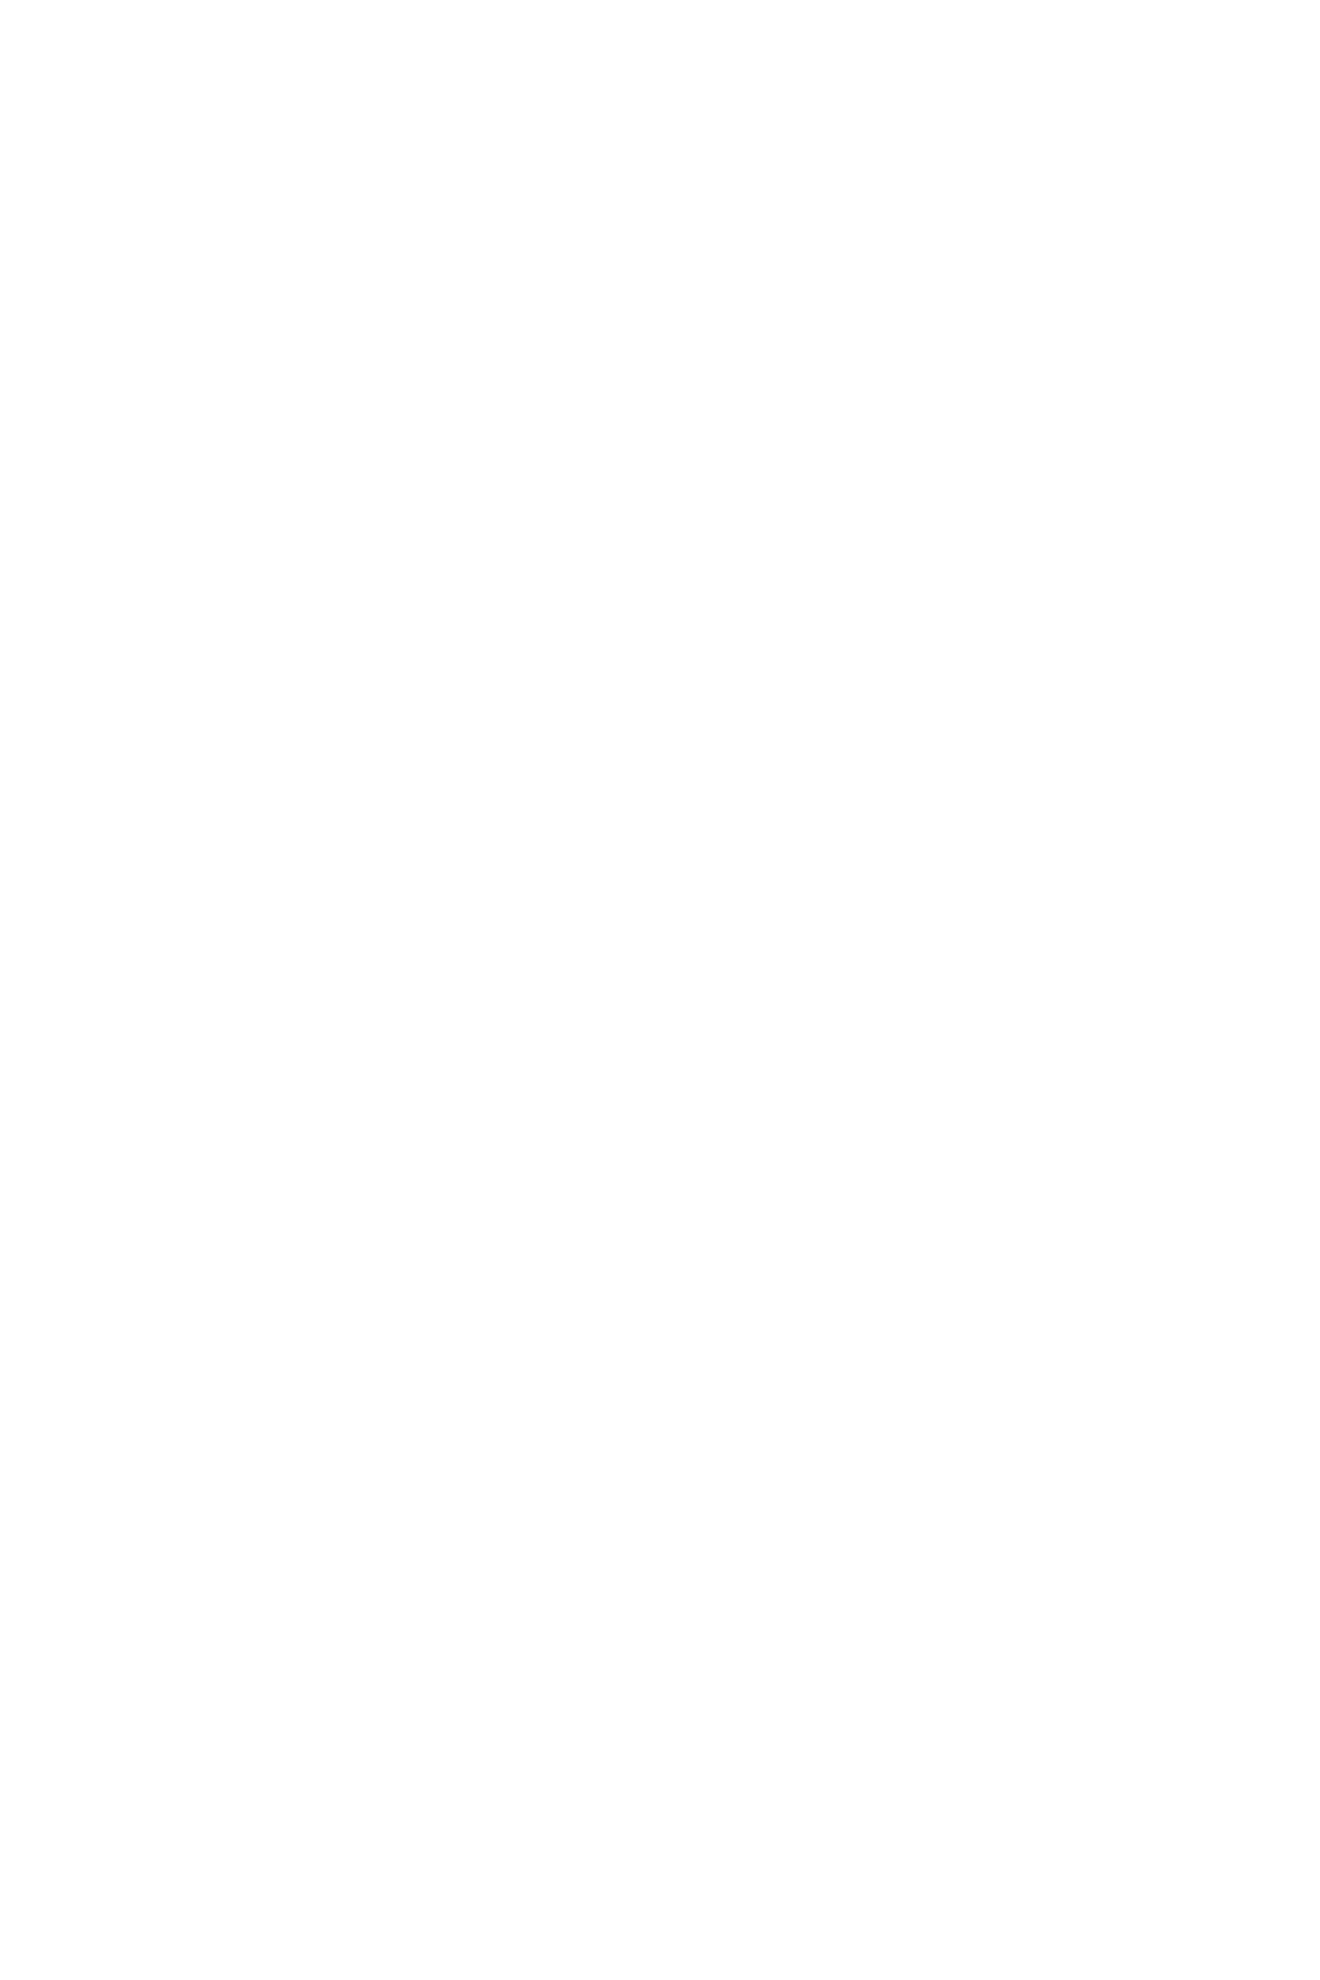

nframes for marker trends 6
marker TRENDS for irep= 0
# of walkers,steps 30 600


<IPython.core.display.Javascript object>


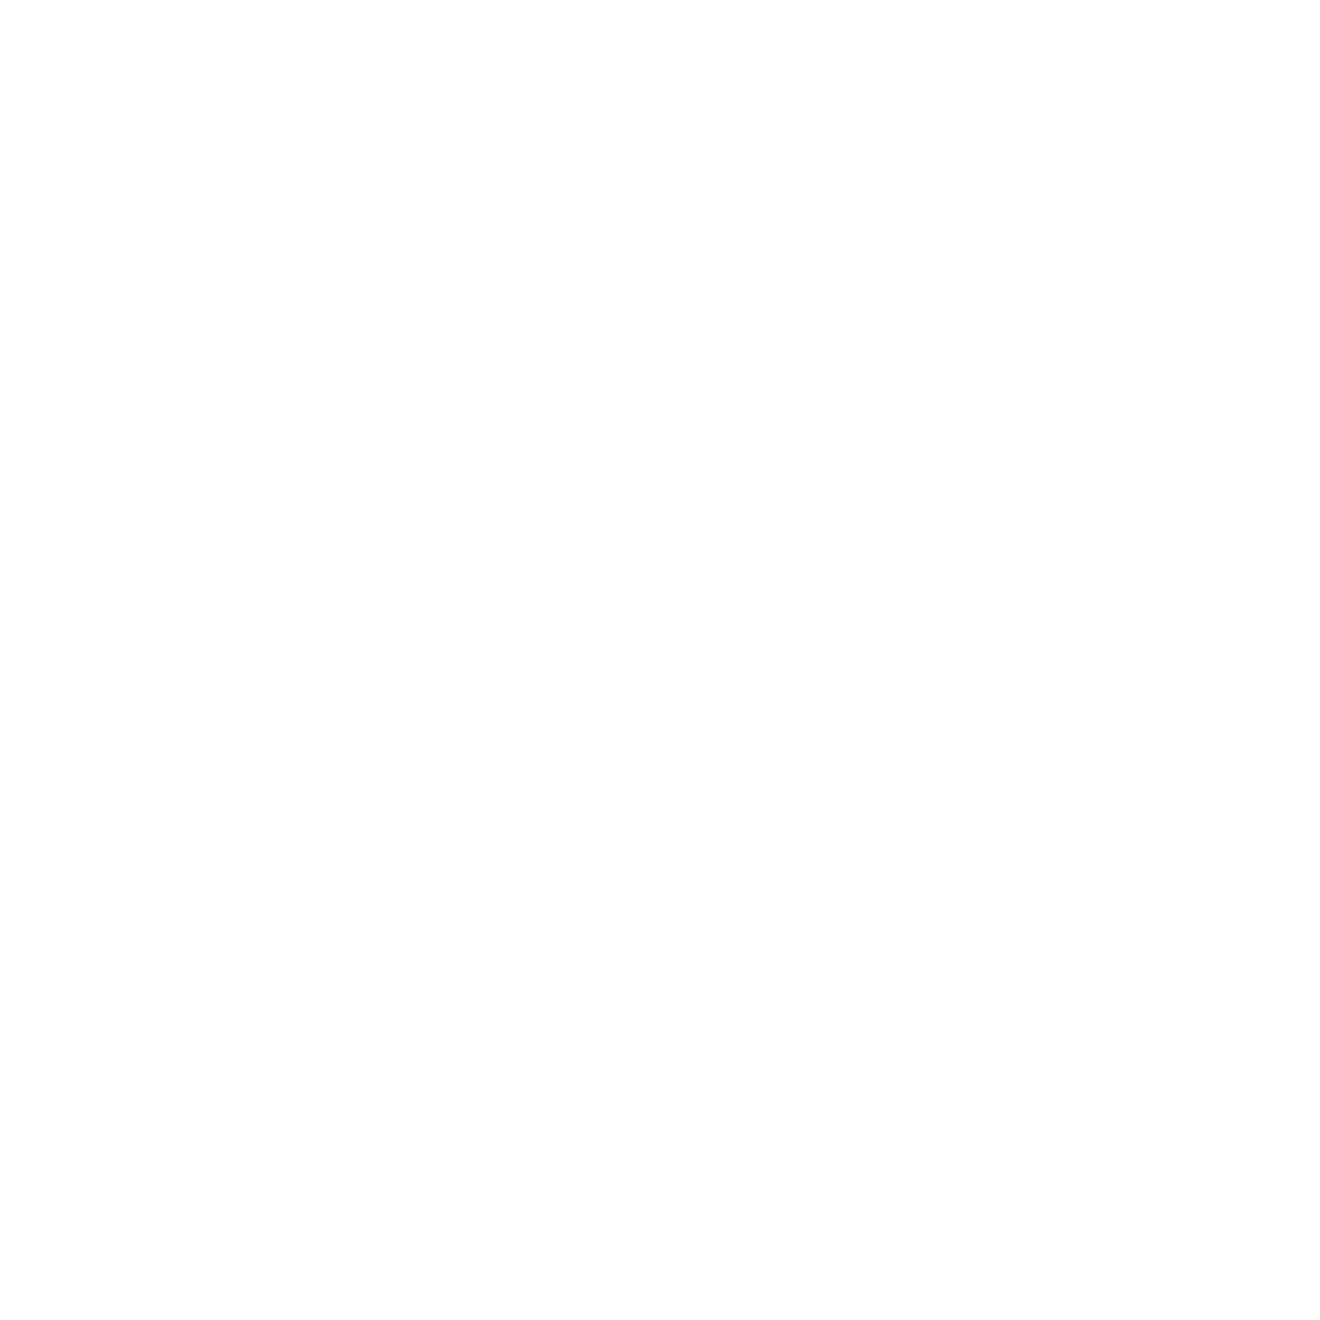

TRIANGLE for irep= 0


<IPython.core.display.Javascript object>


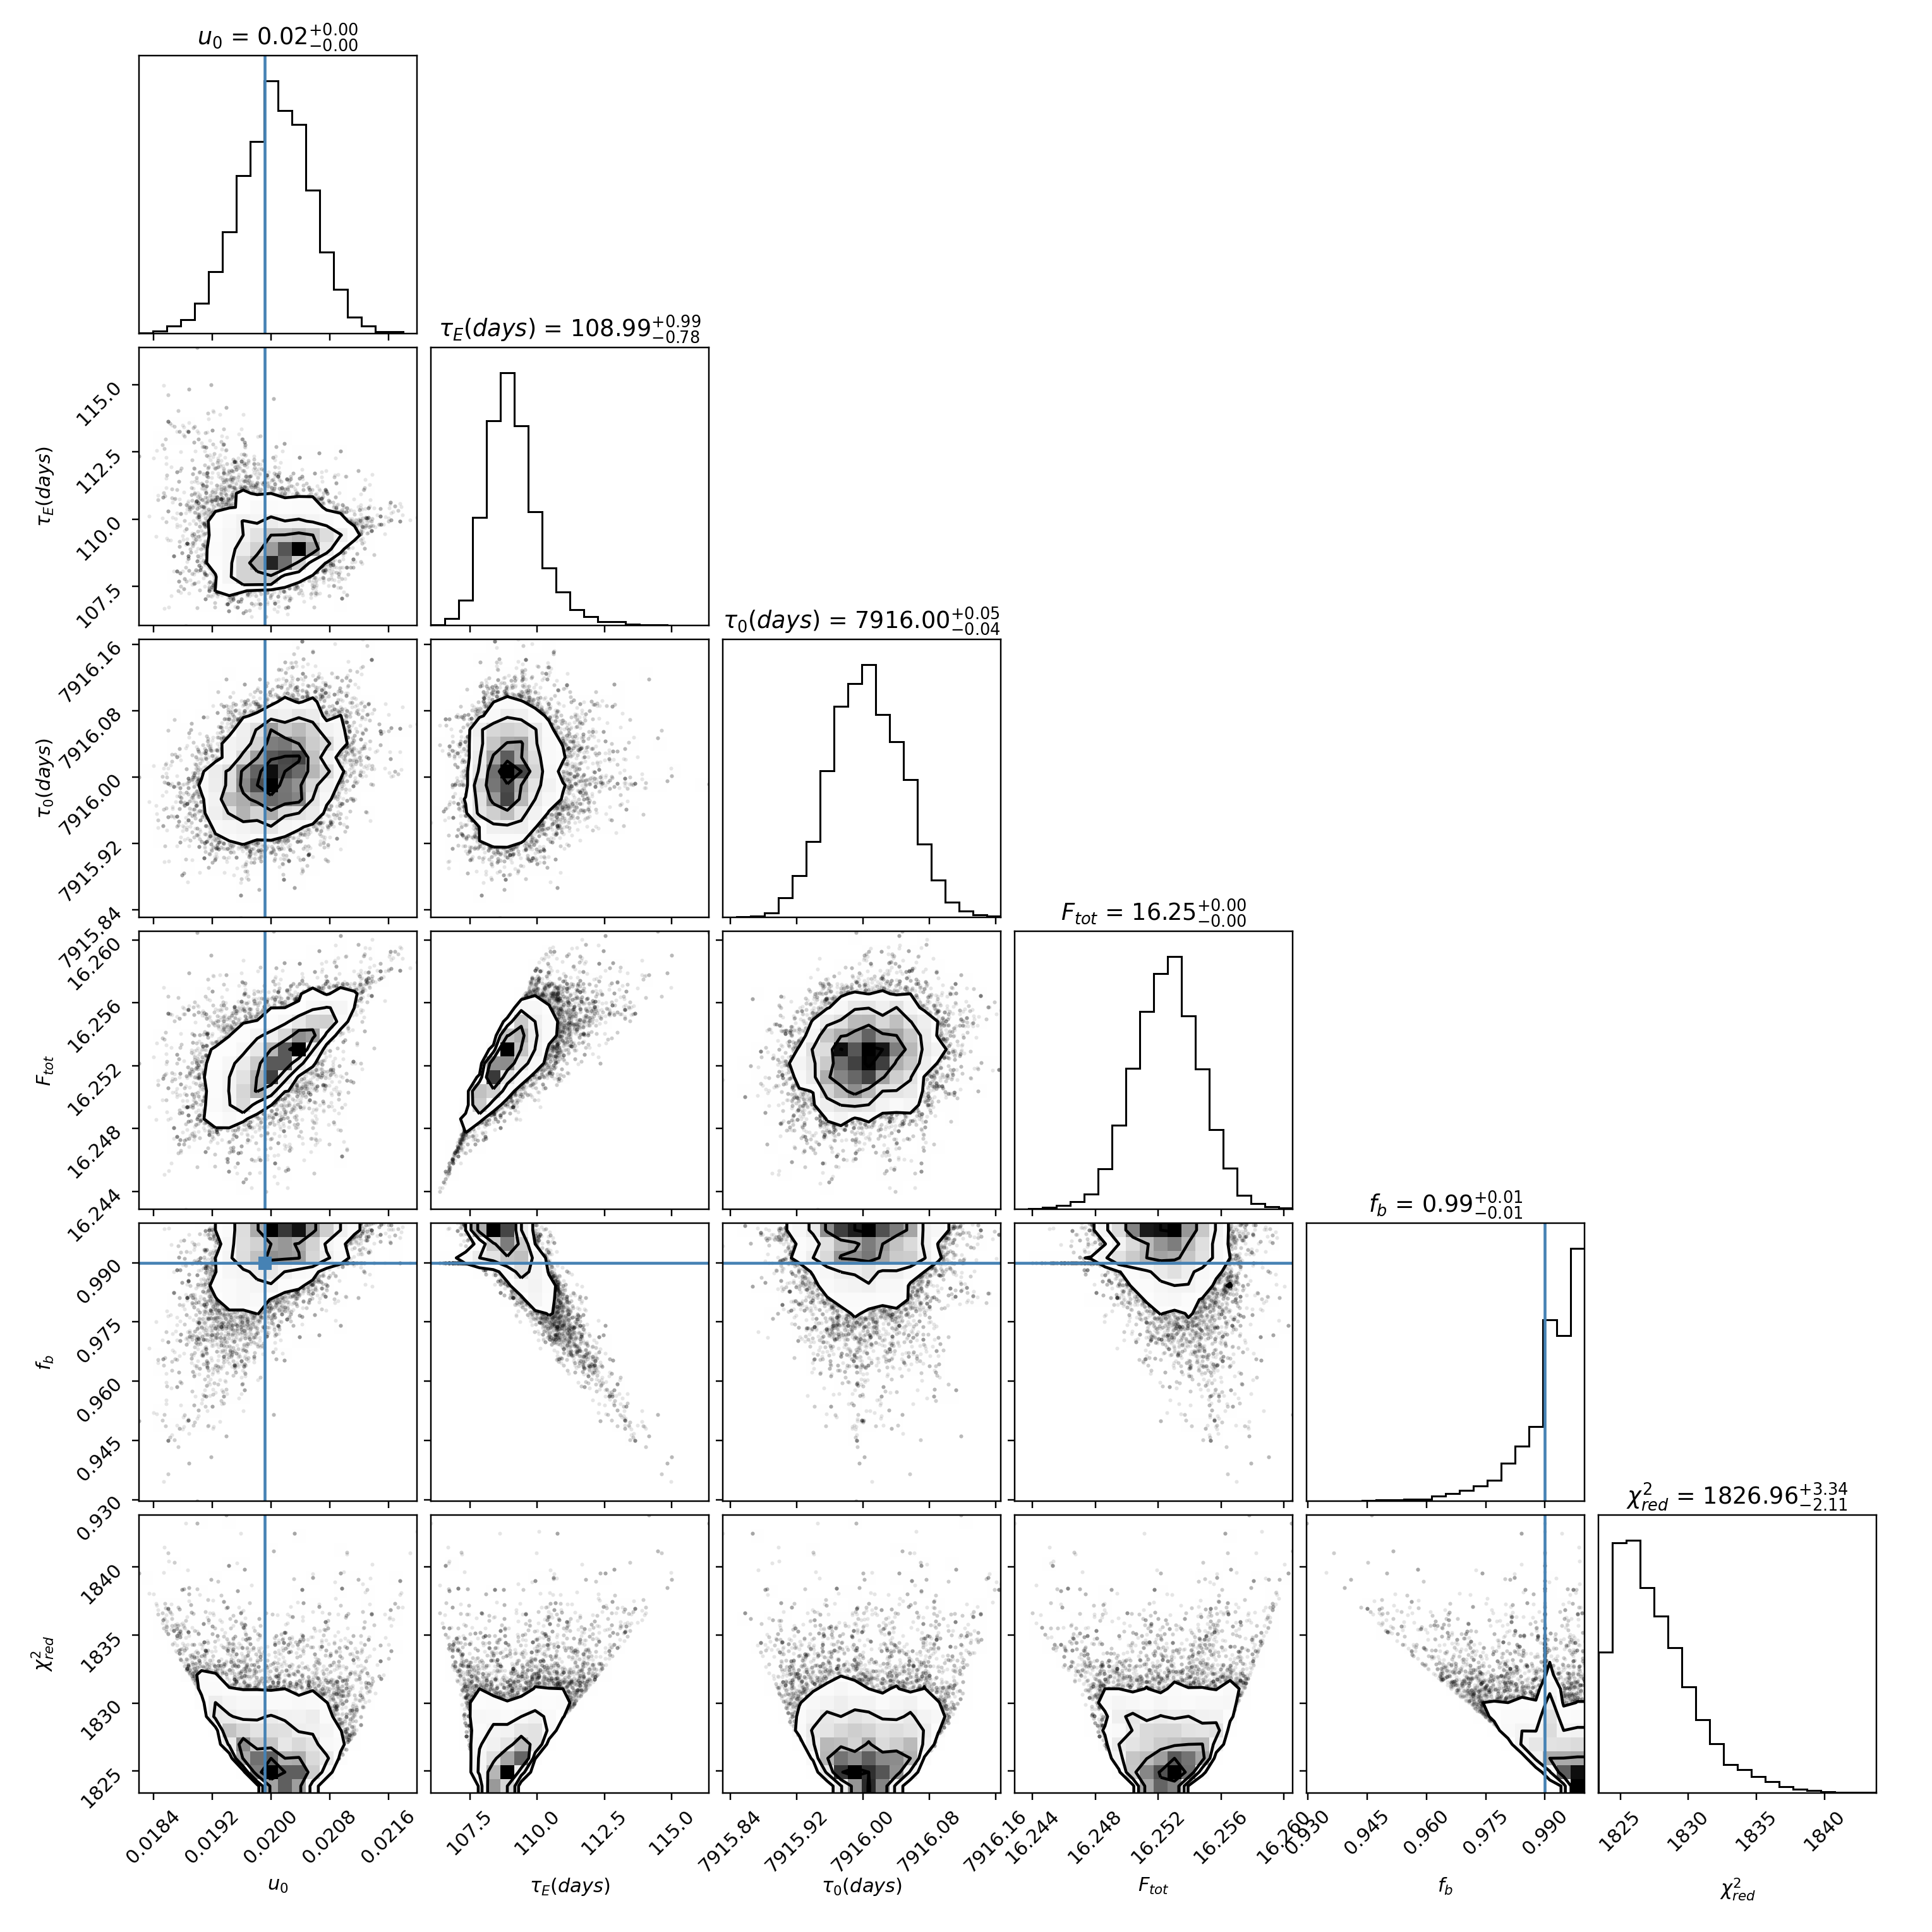

u0, error 0.020222720774864797 0.0004791617848234602
t0, error 7916.003989545309 0.04345424959637967
tE, error 108.32254745787982 0.8833412117819393
Ftot, error 16.251937796728942 0.0020670674555738344
Fb, error 0.999919761485429 0.0068929620313492035


In [23]:
import mcmcFit as mcfit
%timeit
 # name of source file 

u0,t0,tE,Ftot,fb,u0err,t0err,tEerr,Ftoterr,fberr = mcfit.mcmcFit(filename,ukirt_time,ukirt_mag,ukirt_error,initial_u0,initial_t0-2450000,initial_tE)

print('u0, error',u0,u0err)
print('t0, error',t0,t0err)
print('tE, error',tE,tEerr)
print('Ftot, error',Ftot,Ftoterr)
print('Fb, error',fb,fberr)


In [11]:
print('u0 =',u0,'t0 =',t0+2450000,'tE =',tE) #fixed input parameters to the mulens model. 

NameError: name 'u0' is not defined

In [12]:
data = mm.MulensData(file_name=ukirt_data)

FileNotFoundError: [[2.45786402e+06 1.53240000e+01 8.60000000e-02]
 [2.45786406e+06 1.54180000e+01 8.50000000e-02]
 [2.45786411e+06 1.53190000e+01 8.60000000e-02]
 ...
 [2.45873476e+06 1.66710000e+01 2.46000000e-01]
 [2.45873676e+06 1.69510000e+01 3.11000000e-01]
 [2.45873681e+06 1.67350000e+01 2.55000000e-01]]

In [ ]:
# ***Set time range of planetary perturbation (including 2450000).***
(t_planet_start, t_planet_stop) = (2457917., 2457926.)

# *Set the magnification methods for the planet model*
# VBBL method will be used between t_planet_start and t_planet_stop, 
# and point_source_point_lens will be used everywhere else.
magnification_methods = [
    0., 'point_source_point_lens', 
    t_planet_start, 'VBBL', t_planet_stop, 
    'point_source_point_lens', 2470000.]

In [ ]:
#Basic Point source lense, no companion. 
to = t0 #uses the values calculated above. 
uo = u0
tE = tE

print(to,uo,tE)

#Parameters used 
rho = 0.006 #.0064
#s = 10**0.198
#q = 10**-3.23
#alpha = -0.5 #3.7036

#log_s = np.log10(s)
#log_q = np.log10(q)



# Time range of planetary perturbation (including 2460000).
#(t_anomaly_start, t_anomaly_stop) = (0, 0)

### time when the peak of the planet anomaly occurs (HJD)
#t_anomaly = 0

### duration of the anomaly in days
#delta_t = 0